# Продолжение 1_10_stepic_ml_contest.ipynb

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Взято из комментов
# Для тех, кто уже потерял код, где формировал users_data
event_data = pd.read_csv('data/event_data_train.csv')
submission_data = pd.read_csv('data/submissions_data_train.csv')
event_data['date'] = pd.to_datetime(event_data.timestamp, unit ='s')
event_data['day'] = event_data.date.dt.date

submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit = 's')
submission_data['day'] = submission_data.date.dt.date

users_data = event_data.groupby('user_id', as_index= False)\
    .agg({'timestamp': 'max'})\
    .rename({'timestamp':'last_timestamp'}, axis = 'columns')
now = 1526772811
drop_out_threasold = 2592000

users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threasold
users_scores = submission_data.pivot_table(index='user_id',
                                           columns = 'submission_status',
                                           values = 'step_id',
                                           aggfunc = 'count',
                                           fill_value = 0)\
    .reset_index()
users_data = users_data.merge(users_scores, on = 'user_id', how = 'outer')
users_data = users_data.fillna(0)
users_invent_data = event_data.pivot_table(index ='user_id',
                                           columns = 'action',
                                           values  = 'step_id',
                                           aggfunc = 'count',
                                           fill_value = 0).reset_index()
users_data = users_data.merge(users_invent_data, how = 'outer')
users_days = event_data.groupby('user_id').day.nunique()
users_days.to_frame().reset_index()
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')
users_data['passed_corse'] = users_data.passed > 170

Данные лежат по ссылке: https://stepik.org/lesson/226979/step/1?unit=199528

In [3]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Взято из комментариев:
Для тех, кто как и я, забыл о чем вообще речь, следующая расшифровка колонок датасета:

user_id - идентификатор юзера
last_timestamp - время наступления последнего события в формате unix date
is_gone_user - признак ушедшего с курса юзера
correct - кол-во верных решений
wrong - кол-во попыток (неверных) решений
discovered - кол-во событий "пользователь перешел на степ"
passed - кол-во событий "удачное решение практического шага"
started_attempt - кол-во событий "начало попытки решить шаг"
viewed - кол-во событий "просмотр шага"
day - кол-во дней проведенных на курсе
passed_course - признак завершения юзером курса

# Step 3

In [4]:
users_data[users_data.passed_corse].day.median()

20.0

<AxesSubplot:>

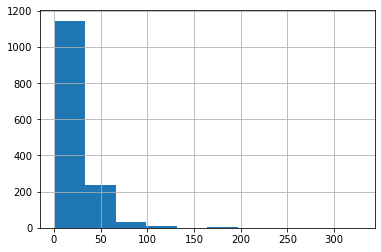

In [5]:
users_data[users_data.passed_corse].day.hist()

In [6]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [7]:
# Отберем данные по событиям первых трех дней, именно для них будем пытаться предсказать уход пользователя.
# Найдем для начал минимальное время для каждого пользователя
user_min_time = event_data.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'min'})\
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [8]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [9]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [10]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [11]:
event_data_train = pd.DataFrame()


In [12]:
# Неправильный способ, поскольку это будет долго исполнятся
# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_threshold = min_user_time + 3 * 24 * 60 * 60
#
#     user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]
#     event_data_train = event_data_train.append(user_events_data)

In [13]:
# Правильный способ из комментов
time_threshold = 3 * 24 * 60 * 60
event_data = event_data.merge(users_data[['user_id', 'min_timestamp']], how='outer')
event_data_train = event_data[(event_data.timestamp - event_data.min_timestamp) <= time_threshold]

In [14]:
event_data_train =  event_data_train.drop('min_timestamp', axis=1)
event_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [15]:
event_data_train.shape

(1014985, 6)

In [16]:
# Правильный способ от создателя курса (хотя это спорно)
event_data['user_time'] = event_data.user_id.map(str) + '_' + event_data.timestamp.map(str)
# event_data_train = events_data[events_data.user_id]
event_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895


In [17]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [18]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [19]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [20]:
event_data = event_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [21]:
event_data.shape

(3480703, 9)

In [22]:
event_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


In [23]:
events_data_train = event_data[event_data.user_time <= event_data.user_learning_time_threshold]

In [24]:
events_data_train.shape

(1014985, 9)

In [25]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


In [26]:
# events_data.head()
# wrong_step = events_data[events_data.action == 'wrong']
# wrong_step
# events_data.action.unique()
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [27]:
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [28]:
wrong_step = submission_data[submission_data.submission_status == 'wrong']\
    .groupby('step_id')\
    .agg({'step_id': 'count'})\
    .rename({'step_id': 'count'}, axis='columns')

In [29]:
wrong_step.sort_values('count', ascending=False)['count']

step_id
31978    16084
32031    13373
32202    13002
33481    10300
32075    10003
         ...  
33482      707
33681      703
33362      673
32175      342
32929       85
Name: count, Length: 76, dtype: int64

In [30]:
events_data_train = event_data[event_data.user_time <= event_data.user_learning_time_threshold]
event_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


In [31]:
events_data_train.drop('min_timestamp', inplace=True, axis='columns')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [33]:
# у нас задача предсказать уйдет ли пользователь за данные по 3-м дням
# Проверим что ничего не сломали, убедимся что больше четырех дней (начал в середине первого дня закончил утром 4-го в итоге это 3 суток но 4 дня) не будет уникальных дней, поскольку мы искали пользователей за 3 дня
events_data_train.groupby('user_id').day.nunique().max()

4

In [34]:
# Повторим проделанные дейсвтия и над submissions_data
submission_data['user_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submission_data_train = submission_data[submission_data.user_time <= submission_data.user_learning_time_threshold]
submission_data_train.groupby('user_id').day.nunique().max()

4

In [35]:
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns={'day': 'days'})

In [36]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [37]:
# посчитаем сколько первых степов сделал человек за первые 3 дня
steps_tried = submission_data_train.groupby('user_id')\
    .step_id.nunique().to_frame().reset_index()\
    .rename(columns={'step_id': 'steps_tried'})

In [38]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [39]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [40]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [41]:
X.shape

(8913, 3)

In [42]:
# Посчитаем количество правильных, не правильных попыток за первые 3 дня
X = X.merge(submission_data_train.pivot_table(index='user_id',
                                  columns='submission_status',
                                  values='step_id',
                                  aggfunc='count',
                                  fill_value=0).reset_index())

In [43]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [44]:
# Введем отношение суммы правильных ответов от всех ответов, которые человек дал.
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [45]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [46]:
# Просмотрим сколько данных было просмотренных степов суммарно.
X = X.merge(events_data_train.pivot_table(index='user_id',
                                          columns='action',
                                          values='step_id',
                                          aggfunc='count',
                                          fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [47]:
X.shape

(19234, 7)

In [48]:
# Заполним пропуски в данных нулем.
X = X.fillna(0)

In [49]:
# Возьмем данные о том что человек прошел курс успешно и правда ли что он больше не пытается это сделать.
X = X.merge(users_data[['user_id', 'passed_corse', 'is_gone_user']], how='outer')

In [50]:
# Отбросим пользователей которые еще не являются ушедшими и при этом еще не закончили курс
X = X[~((X.is_gone_user == False) & (X.passed_corse == False))]
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [51]:
X.groupby(['passed_corse', 'is_gone_user']).user_id.count()

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

In [52]:
# Полчается для нас целевой переменной является passed_corse и возьмем её в y
y = X.passed_corse.map(int)

In [53]:
X = X.drop(['passed_corse', 'is_gone_user'], axis='columns')

In [54]:
# Поскольку нам не понадобиться для обучения user_id поскольку это рандомизированное значение и врядли будет полезно при обучении, мы можем сохранить user_id в качестве индекса
X = X.set_index(X.user_id)
X = X.drop('user_id', axis='columns')
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
